In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import json
from datasets import load_dataset
import os

dataset = load_dataset("gsm8k", "main")
train_questions = np.array(dataset["train"]["question"])
train_answers = np.array(dataset["train"]['answer'])

test_questions = np.array(dataset["test"]["question"])
test_answers = np.array(dataset["test"]['answer'])


In [28]:
def get_stats(train_name):
    train_accs_all = []
    perplexities_all = []


    ckpts = sorted([
    f for f in os.listdir("ckpts/"+train_name) if os.path.isdir(os.path.join("ckpts/"+train_name, f))
    ], key=lambda x: int(x.split('-')[1]))
    # print(ckpts)

    for ckpt in ckpts:
        try:
            train_correct = (np.load("ckpts/"+train_name+"/"+ckpt+ "/train_answer_types5_seed2_temp0.8.npy")==0)
            
        except:
            try:
                train_correct = (np.load("ckpts/"+train_name+"/"+ckpt+ "/train_answer_types50_seed2_temp0.8.npy")==0)
            except:
                try:
                    train_correct = (np.load("ckpts/"+train_name+"/"+ckpt+ "/train_answer_types50_seed2.npy")==0)
                except:
                    train_correct = (np.load("ckpts/"+train_name+"/"+ckpt+ "/train_answer_types10_seed2_temp0.8.npy")==0)
        train_accs = train_correct.mean(axis=-1)
        train_accs_all.append(train_accs)
        
        perplexities = np.load("ckpts/"+train_name+"/"+ckpt+ "/train_perplexities.npy")
        perplexities_all.append(perplexities)
        
    subsample_idxs = np.load("ckpts/"+train_name+"/subsample_idxs.npy")
    
    train_accs_all = np.array(train_accs_all)[:, subsample_idxs]
    perplexities_all = np.array(perplexities_all)[:, subsample_idxs]
    
    
    
    test_accs_all = []

    for ckpt in ckpts:
        try:
            test_accs = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answer_types50_seed2.npy")==0)
        except:
            try:
                test_accs = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answer_types50_seed2_temp0.8.npy")==0)
            except:
                test_accs = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answer_types5_seed2_temp0.8.npy")==0)
        test_accs_all.append(test_accs)

    test_accs_all = np.array(test_accs_all)
    
    return_dict = {}
    return_dict["train_accs_all"] = train_accs_all
    return_dict["perplexities_all"] = perplexities_all
    return_dict["test_accs_all"] = test_accs_all
    
    return return_dict




def get_ratios2(stats_dict, perp_threshold=-2.5):
    train_accs_all = stats_dict["train_accs_all"]
    perplexities_all = stats_dict["perplexities_all"]
    test_accs_all = stats_dict["test_accs_all"]
    
    memorization_mask = np.ones(train_accs_all.shape)*-1
    accs_all = np.ones(train_accs_all.shape)*-1
    
    for i in range(len(train_accs_all)):

        accs_all[i] =train_accs_all[i]
        
        memorization_mask[i] = (np.log(np.log((perplexities_all[i]))) >= perp_threshold)
    
    
    
    
    unmemorized_acc_cummax = np.array([(accs_all*memorization_mask)[:j+1].max(axis=0) for j in range(len(train_accs_all))])
    
    # print(unmemorized_acc_cummax.shape)
    # print(accs_all.shape)
    unmemorized_acc_cummax = (np.min([unmemorized_acc_cummax, accs_all], axis=0))
    unmemorized_acc_cummax_mean = unmemorized_acc_cummax.mean(axis=1)
    

    avg_test_acc = test_accs_all.mean(axis=1).mean(axis=1)
    
    
    
    return_dict = {}
    
    
    return_dict["unmemorized_acc_cummax"] = unmemorized_acc_cummax_mean
    return_dict["unmemorized_acc_cummax_all"] = unmemorized_acc_cummax

    return_dict["avg_test_acc"] = avg_test_acc
            
    return return_dict


In [36]:
# stats_dict5 = get_stats("gsm8k_orig_6epochs_full_lr5e-05_bs128")
# stats_dict7 = get_stats("gsm8k_orig_6epochs_full_lr5e-07_bs128")
# stats_dict4 = get_stats("gsm8k_orig_6epochs_full_lr0.0002_bs128")

stats_dict5 = get_stats("gsm8k_orig_6epochs_half_lr2e-05_bs128")
stats_dict7 = get_stats("gsm8k_orig_12epochs_quarter_lr2e-05_bs128")
stats_dict4 = get_stats("gsm8k_orig_24epochs_eighth_lr2e-05_bs128")


In [42]:
perp_threshold=-2.4

ratios_dict5 =  get_ratios2(stats_dict5, perp_threshold=perp_threshold)
ratios_dict7 =  get_ratios2(stats_dict7, perp_threshold=perp_threshold)
ratios_dict4 =  get_ratios2(stats_dict4, perp_threshold=perp_threshold)

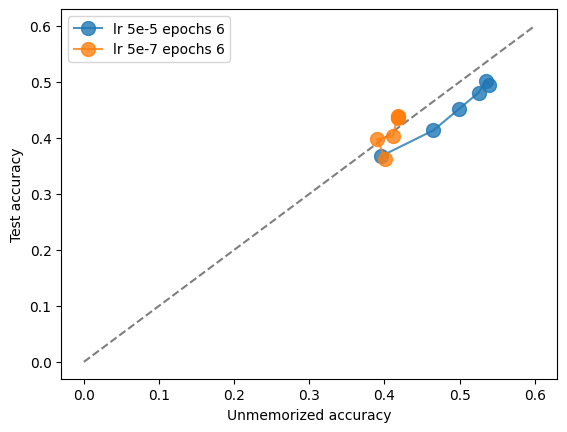

In [43]:
plt.plot([0, 0.6], [0, 0.6], "--", color="black", alpha=0.5)


plt.plot(ratios_dict5["unmemorized_acc_cummax"], ratios_dict5["avg_test_acc"], "o-", markersize=10, c="C0", alpha=0.8, label="lr 5e-5 epochs 6")
plt.plot(ratios_dict7["unmemorized_acc_cummax"], ratios_dict7["avg_test_acc"], "o-", markersize=10, c="C1", alpha=0.8, label="lr 5e-7 epochs 6")
# plt.plot(ratios_dict4["unmemorized_acc_cummax"], ratios_dict4["avg_test_acc"], "o-", markersize=10, c="C2", alpha=0.8, label="lr 2e-4 epochs 6")



plt.legend()
plt.xlabel("Unmemorized accuracy")
plt.ylabel("Test accuracy")
plt.savefig("delete.png")

In [15]:
from sklearn.linear_model import LinearRegression


r_squared_all =[]

for acc_threhshold in [2.5]:
    r_squared_i = []
    for perp_threshold in [-2.3, -2.4, -2.5, -2.6, -2.7]:


        ratios_dict5 = get_ratios2(stats_dict5, perp_threshold)
        ratios_dict7 = get_ratios2(stats_dict7, perp_threshold)
        ratios_dict4 = get_ratios2(stats_dict4, perp_threshold)
        
        # Example data
        x = np.concatenate([ratios_dict5["unmemorized_acc_cummax"], ratios_dict7["unmemorized_acc_cummax"], ratios_dict4["unmemorized_acc_cummax"]])
        y = np.concatenate([ratios_dict5["avg_test_acc"], ratios_dict7["avg_test_acc"], ratios_dict4["avg_test_acc"]])

        x = x.reshape(-1, 1)

        # Linear regression model
        model = LinearRegression()
        model.fit(x, y)

        # R^2 score
        r_squared = model.score(x, y)

        print(f"accuracy threshold: {acc_threhshold}")
        print(f"perplexity threshold: {perp_threshold}")
        print(f"R^2: {r_squared}")
        r_squared_i.append(r_squared)
    r_squared_all.append(r_squared_i)

accuracy threshold: 2.5
perplexity threshold: -2.3
R^2: 0.9577395141125808
accuracy threshold: 2.5
perplexity threshold: -2.4
R^2: 0.9698479068116126
accuracy threshold: 2.5
perplexity threshold: -2.5
R^2: 0.9669227788690957
accuracy threshold: 2.5
perplexity threshold: -2.6
R^2: 0.9556787424287944
accuracy threshold: 2.5
perplexity threshold: -2.7
R^2: 0.9314125503100349
